In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import time
import os
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG3().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/vgg3_experiment')

# Data loading and transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])
# dataset_dir = 'Dataset'
train_dataset = datasets.ImageFolder(r"D:\Users\abhay\Downloads\ML_Classes\ES-335-Assignment-4\Q-1\Dataset\train", transform=transform)
test_dataset = datasets.ImageFolder(r"D:\Users\abhay\Downloads\ML_Classes\ES-335-Assignment-4\Q-1\Dataset\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    global_step = 0  # Keep track of the iteration number across epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().view(-1, 1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Log scalars to TensorBoard
            writer.add_scalar('Training Loss', loss.item(), global_step)
            writer.add_scalar('Training Accuracy', correct_train / total_train, global_step)
            global_step += 1

        # Calculate and log testing accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.float().view(-1, 1).to(device)
                outputs = model(images)
                preds = (outputs > 0.5).float()
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
                
                # Log the images with predictions to TensorBoard once per epoch
                writer.add_images('Test Images', images, epoch)
                writer.add_text('Predictions', str(preds), epoch)

        test_accuracy = correct_test / total_test
        writer.add_scalar('Testing Accuracy', test_accuracy, global_step)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader.dataset):.4f}, "
              f"Train Accuracy: {correct_train / total_train:.4f}, "
              f"Test Accuracy: {test_accuracy:.4f}")

    writer.close()

# Run training
start_time = time.time()
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Epoch [1/10], Train Loss: 0.6942, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [2/10], Train Loss: 0.6939, Train Accuracy: 0.5000, Test Accuracy: 0.5250
Epoch [3/10], Train Loss: 0.6919, Train Accuracy: 0.5437, Test Accuracy: 0.5750
Epoch [4/10], Train Loss: 0.6911, Train Accuracy: 0.6000, Test Accuracy: 0.6250
Epoch [5/10], Train Loss: 0.6905, Train Accuracy: 0.6312, Test Accuracy: 0.6250
Epoch [6/10], Train Loss: 0.6897, Train Accuracy: 0.6062, Test Accuracy: 0.5750
Epoch [7/10], Train Loss: 0.6887, Train Accuracy: 0.6250, Test Accuracy: 0.6500
Epoch [8/10], Train Loss: 0.6878, Train Accuracy: 0.7063, Test Accuracy: 0.7750
Epoch [9/10], Train Loss: 0.6871, Train Accuracy: 0.7000, Test Accuracy: 0.7000
Epoch [10/10], Train Loss: 0.6856, Train Accuracy: 0.7562, Test Accuracy: 0.7750
Training time: 652.75s


In [4]:
# mke prediction on each image in the test set
model.eval()
correct = 0
for data, target in test_loader:
    # get the inputs; data is a routine tensor
    data, target = data.to(device), target.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    output = model(data)
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred)).sum().item()
    
print(f"Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

Accuracy: 20/40 (50%)


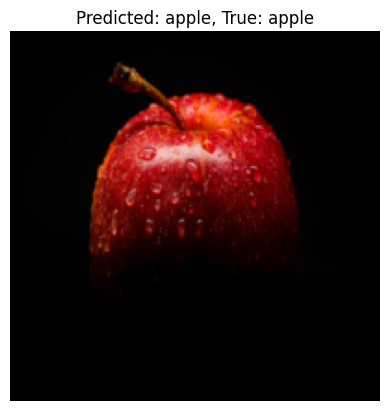

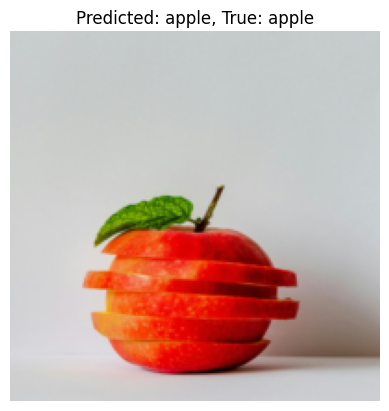

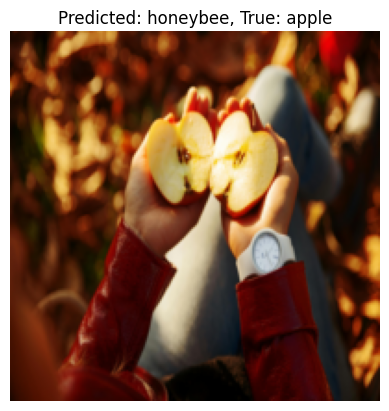

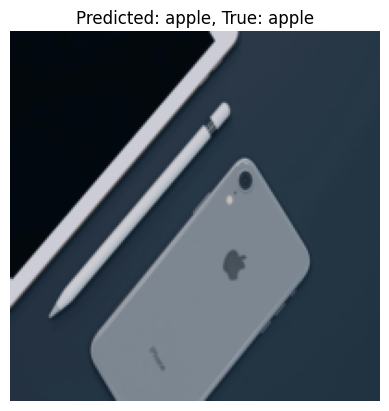

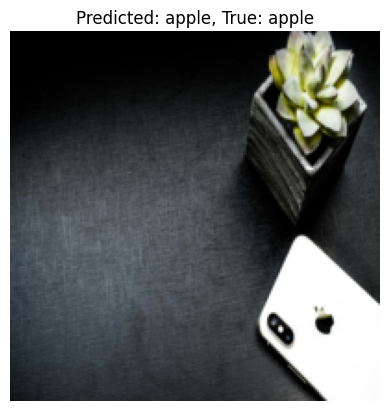

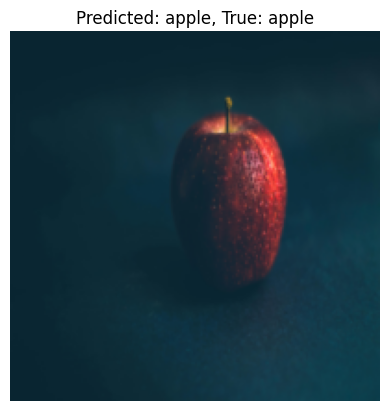

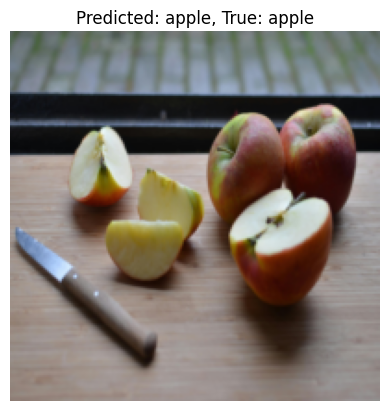

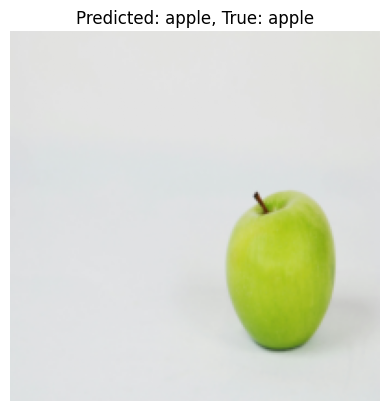

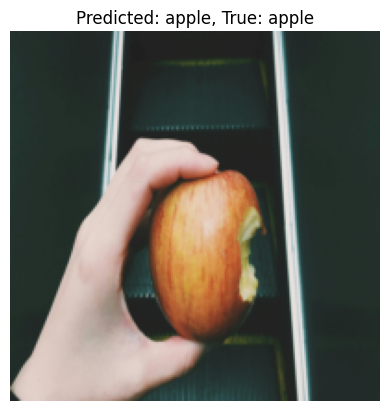

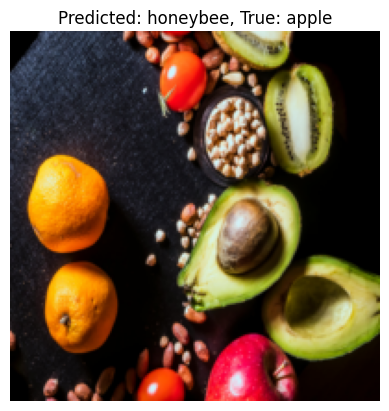

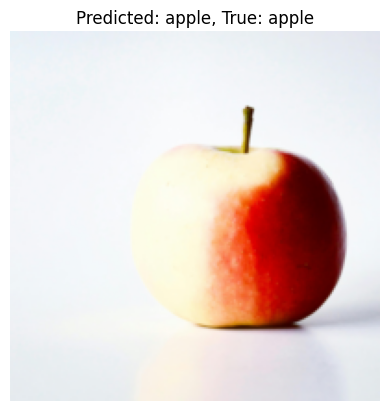

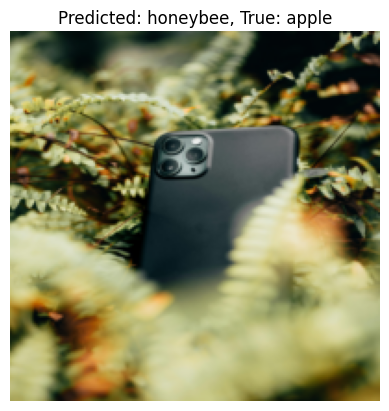

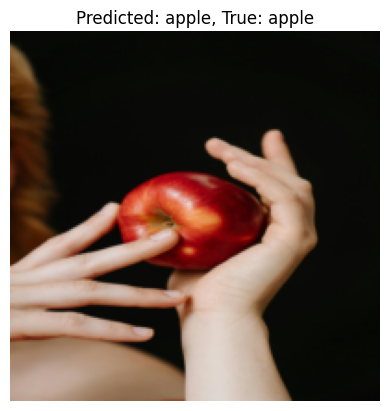

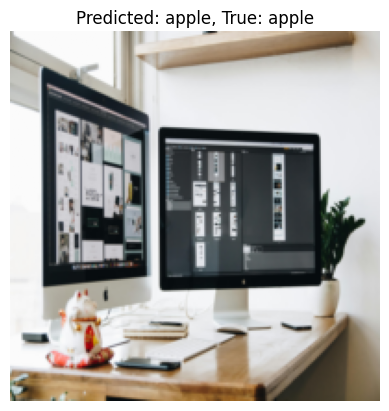

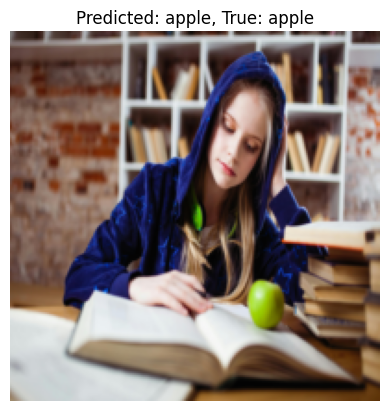

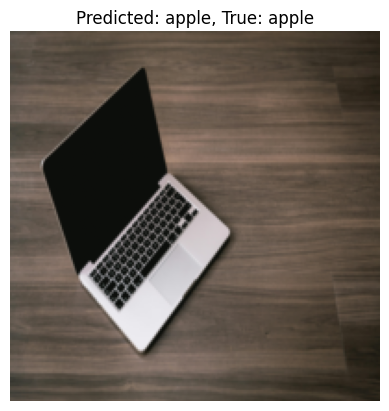

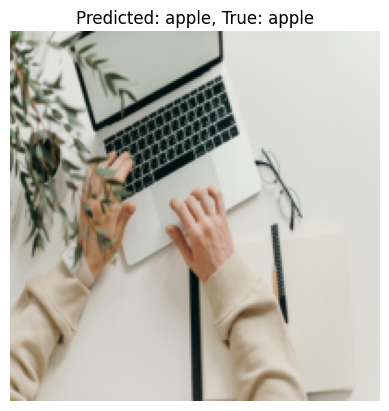

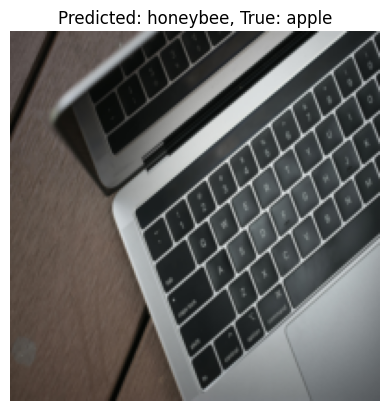

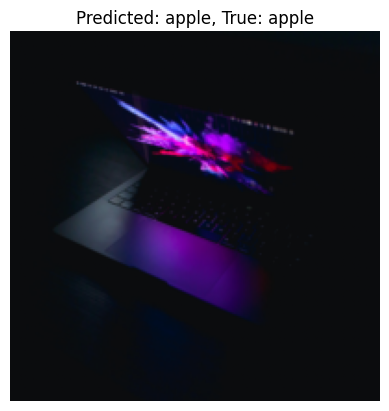

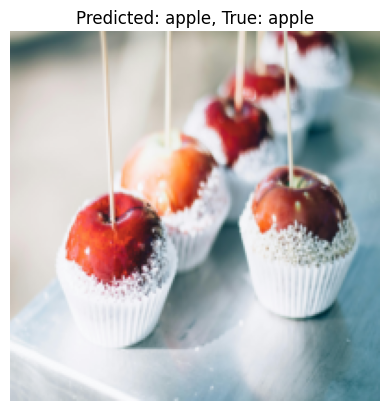

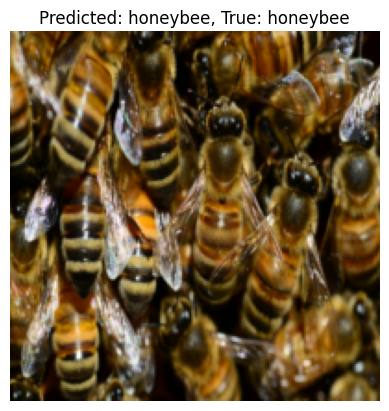

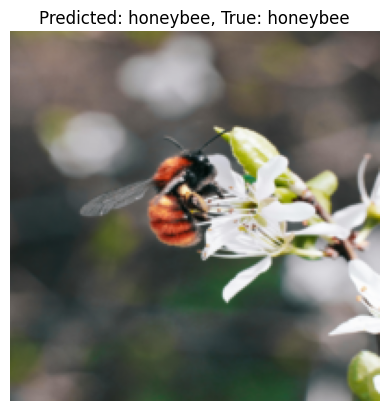

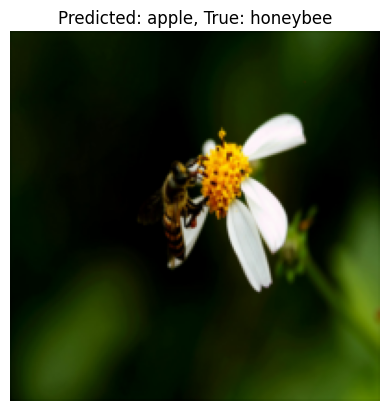

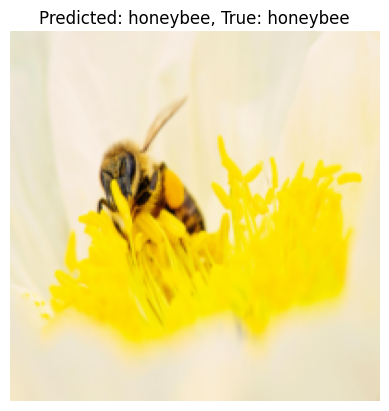

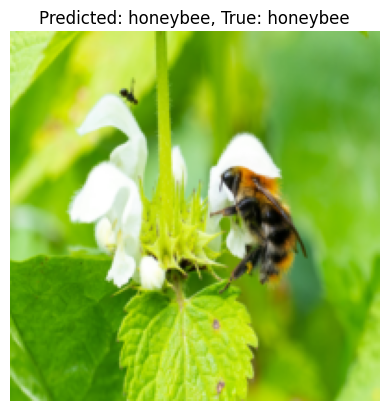

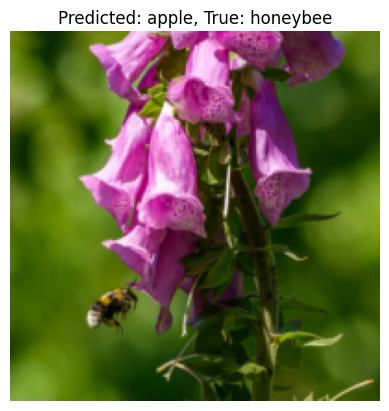

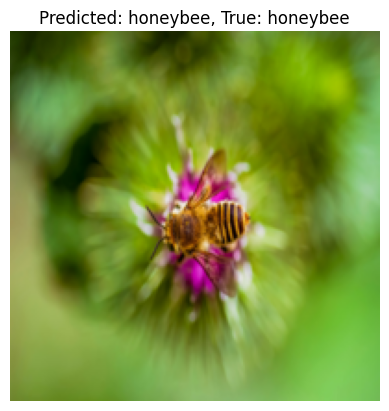

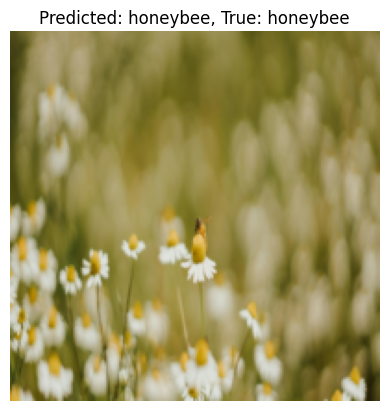

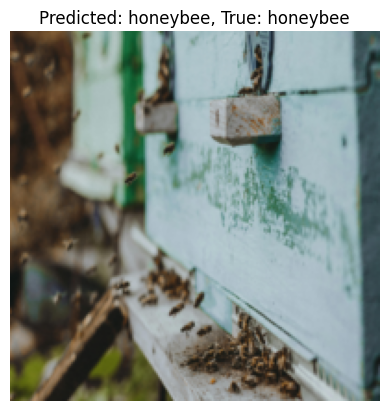

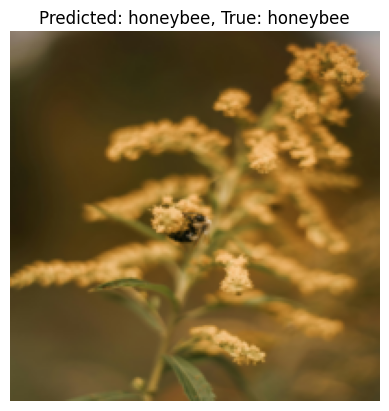

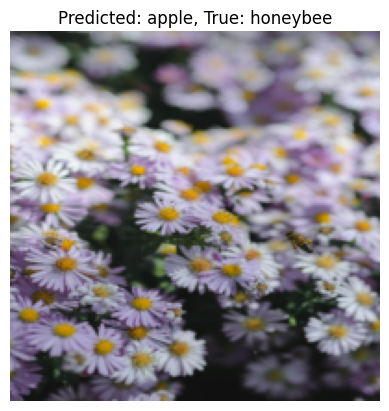

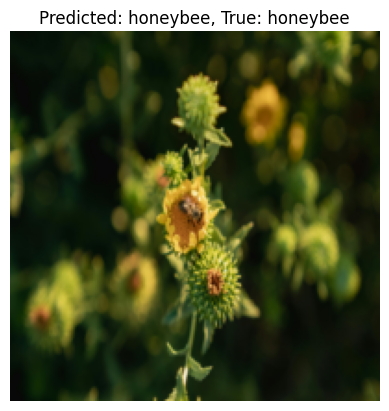

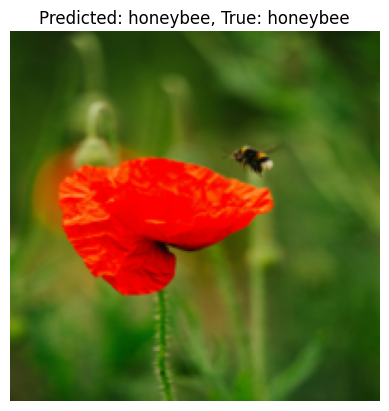

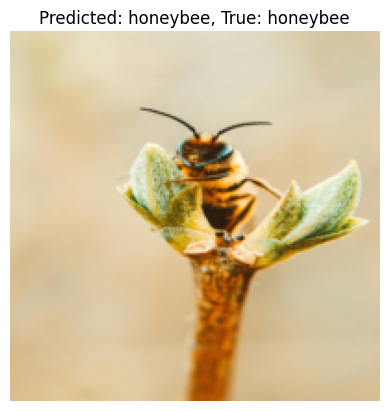

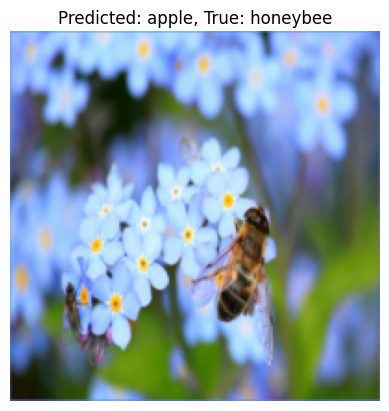

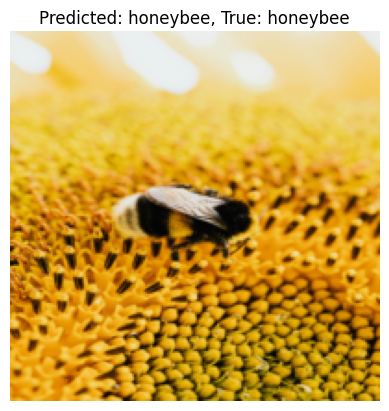

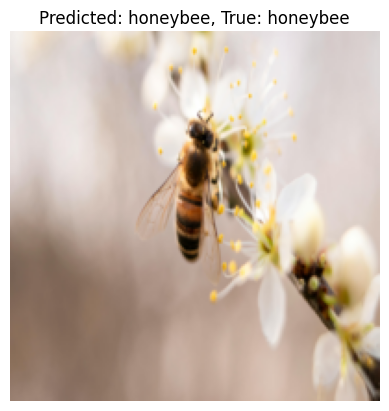

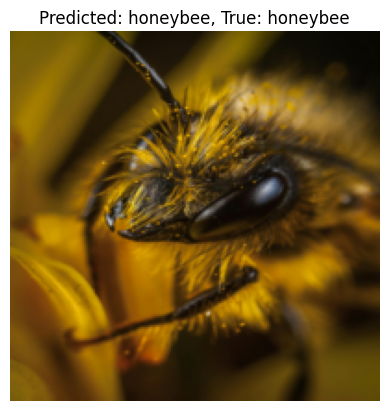

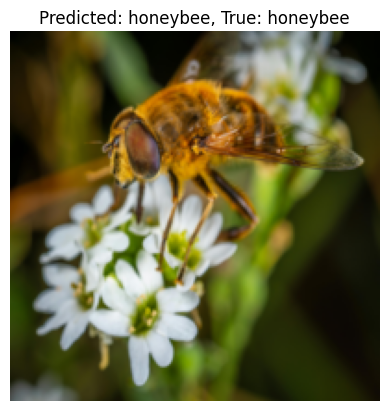

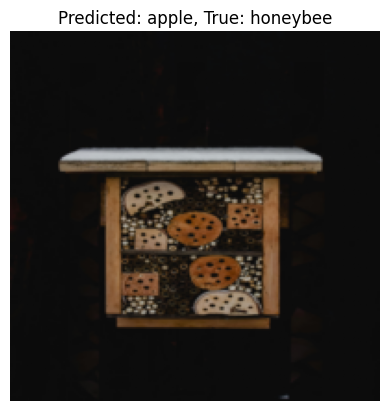

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image and its labels
def show_image(img, pred_label, true_label):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy array and reshape for display
    img = np.clip(img, 0, 1)  # Clip pixel values to be in range [0, 1]
    
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label}, True: {true_label}")
    plt.axis("off")
    plt.show()

# Prediction loop for test images
model.eval()  # Set model to evaluation mode
class_names = test_dataset.classes  # Retrieve class names from the dataset

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        preds = (outputs > 0.5).float().squeeze()  # Convert to binary labels (0 or 1 for binary classification)

        # Display each image with its prediction and true label
        for i in range(images.size(0)):
            img = images[i]
            true_label = class_names[int(labels[i].item())]
            pred_label = class_names[int(preds[i].item())]
            show_image(img, pred_label, true_label)


In [ ]:
model_path = 'vgg3.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")
